In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import pickle

In [ ]:
processed = pd.read_csv('data_prepped.csv')
os.makedirs('plots')

In [3]:
X = processed.drop('Score', axis = 1)
y = processed[['Score']]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(547, 22)
(547, 1)
(137, 22)
(137, 1)


In [5]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=2)

model_rfr.fit(X_train, y_train)

test_on_train = model_rfr.predict(X_train)

c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [6]:
mse_tr = mean_squared_error(y_train, test_on_train)
r2_tr = r2_score(y_train, test_on_train)

print(f'Root Mean Squared Error(on the Training Data): {mse_tr**.5 :.2f}')
print(f'R^2 Score(on the Training Data): {r2_tr*100 :.2f}%')

Root Mean Squared Error(on the Training Data): 0.15
R^2 Score(on the Training Data): 97.74%


In [7]:
pred = model_rfr.predict(X_test)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'Root Mean Squared Error(on the Testing Data): {mse**.5 :.2f}')
print(f'R^2 Score(on the Testing Data): {r2*100 :.2f}%')

Root Mean Squared Error(on the Testing Data): 0.39
R^2 Score(on the Testing Data): 82.83%


In [8]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='r2', 
                           verbose=0)

grid_search.fit(X_train, y_train)

c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
332 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\si

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='r2')

In [9]:
print("Best parameters found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
print(f"Test RMSE: {mse_rf**.5:.2f}, Test R2: {r2_rf*100:.2f}%")


Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Test RMSE: 0.37, Test R2: 84.67%


In [10]:
# Get feature importances
importances = best_rf.feature_importances_

# Match them with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                   Feature  Importance
16                          GDP per Capita    0.186795
21               Perceptions of corruption    0.178764
19            Freedom to make life choices    0.109669
18        Healthy life expectancy at birth    0.106664
17                          Social support    0.099687
20                              Generosity    0.063742
10  Official Core Consumer Price Inflation    0.031816
7        Headline Consumer Price Inflation    0.027243
13                      Continent/Region_1    0.026478
11          GDP deflator Index growth rate    0.026104
8          Energy Consumer Price Inflation    0.022615
9            Food Consumer Price Inflation    0.021022
14                      Continent/Region_2    0.017260
15                      Continent/Region_3    0.013773
12                      Continent/Region_0    0.011211
2                                Country_2    0.010376
0                                Country_0    0.010089
4         

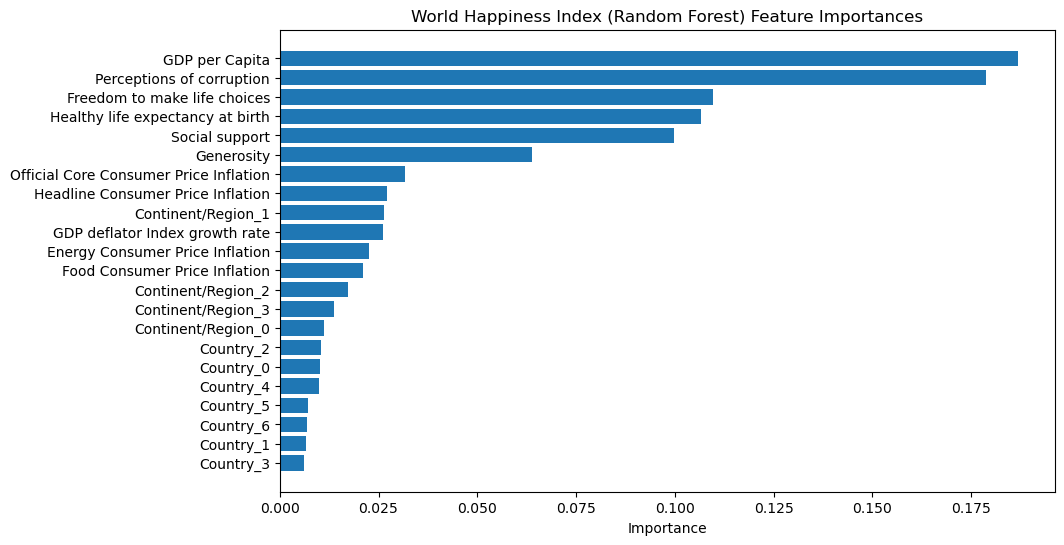

In [13]:
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel("Importance")
plt.title("World Happiness Index (Random Forest) Feature Importances")
plt.savefig("plots/WHI (Random Forest) Feature Importances.png")
plt.show()

In [15]:
# Load the saved model
# with open('random_forest_model.pkl', 'rb') as f:
    # loaded_model = pickle.load(f)

# Use it to make predictions
# predictions = loaded_model.predict(X_test)

In [19]:
y_test_flat = y_test.values.flatten() if isinstance(y_test, pd.DataFrame) else y_test.flatten()
y_pred_flat = y_pred.flatten()

comparison = pd.DataFrame({'Actual': y_test_flat, 'Prediction': y_pred_flat})
print(comparison.head(10))

   Actual  Prediction
0  5.3390    6.031773
1  7.3140    7.369719
2  7.7690    7.262975
3  5.7680    6.106923
4  7.3340    7.226562
5  6.2340    5.975681
6  5.8280    6.066223
7  5.5170    5.840338
8  6.4910    6.380300
9  5.9532    5.835401


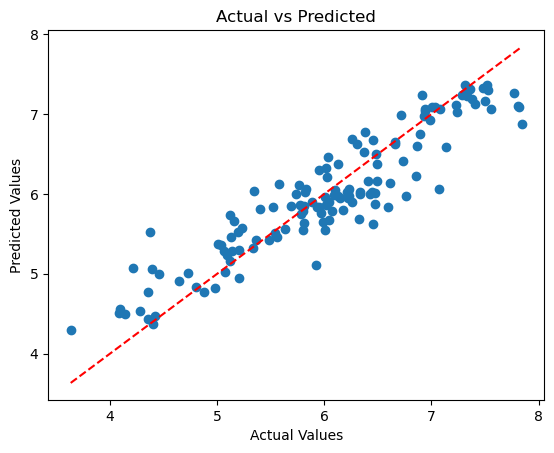

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.savefig('plots/WHI Actual vs Predicted.png')
plt.show()

In [24]:
with open('WHI_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Model saved as 'WHI_model.pkl'")


Model saved as 'WHI_model.pkl'
